In [316]:
import pandas as pd
import numpy as np

# Headers from the horse-colic.names.txt file
data_headers = ['had_surgery','age','hospital_number','rectal_temp','pulse',
    'resp_rate','temp_of_extremities','peripheral_pulse','mucous_membrane',
    'capillary_refill_time','pain','peristalsis','abdominal_distension',
    'nasogastric_tube','nasogastric_reflux','nasogastric_reflux_PH',
    'rectal_examination_feces','abdomen','packed_cell_volume','total_protein',
    'abdominocentesis_appearance','abdomcentesis_total_protein','outcome',
    'had_surgical_lesion','lesion_site','lesion_type','lesion_subtype',
    'lesion_specific_code','cp_data']

# Load the dataset
data = pd.read_csv('uci-horse-colic-data/horse-colic.data.csv',sep=' ',names=data_headers)
test_data = pd.read_csv('uci-horse-colic-data/horse-colic.test.csv',sep=' ',names=data_headers)

# The cp_data column contains no data, can delete this.
data = data.drop('cp_data', axis=1)
test_data = test_data.drop('cp_data', axis=1)

# The data contains ? in place of missing/NaN data. Change this.
data[data == '?'] = np.nan
data.astype(dtype=float)
print('Dataset size: ', data.shape)

test_data[test_data == '?'] = np.nan
test_data.astype(dtype=float)
print('Test dataset size: ', test_data.shape)

# Remove data missing outcome
missing_outcome = data[data.outcome.isnull()]
data = data.drop(missing_outcome.index)

missing_outcome = test_data[test_data.outcome.isnull()]
test_data = test_data.drop(missing_outcome.index)

# Null or missing data
#print(data.isnull().sum())
num_missing_data = data.isnull().any(axis=1).sum()
print('\nTotal empty data points: ', num_missing_data)

num_missing_test_data = test_data.isnull().any(axis=1).sum()
print('Total empty test data points: ', num_missing_test_data)


Dataset size:  (300, 28)
Test dataset size:  (68, 28)

Total empty data points:  293
Total empty test data points:  66


In [317]:
import pandas as pd
# Make some changes to the dataframe

# Convert outcome to words
def outcome_str(y):
    outcomes = []
    for val in y:
        if val == '1':
            outcome = 'lived'
        elif val == '2':
            outcome = 'died'
        elif val == '3':
            outcome = 'euthanized'
        outcomes += [outcome]
    return outcomes

# Add new column with outcome in words
data.insert(0, 'outcome_in_words', outcome_str(data['outcome']),True)
test_data.insert(0, 'outcome_in_words', outcome_str(test_data['outcome']),True)

# Makes more sense for 'had_surgery' to be either 0 or 1
data['had_surgery'] = data['had_surgery'].replace('2','0')
test_data['had_surgery'] = test_data['had_surgery'].replace('2','0')

# The age column has incorrect numbers (9 should be 2)
data['age'] = data['age'].replace(9,2)
test_data['age'] = test_data['age'].replace(9,2)

data.head()

,outcome_in_words,had_surgery,age,hospital_number,rectal_temp,pulse,resp_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdominocentesis_appearance,abdomcentesis_total_protein,outcome,had_surgical_lesion,lesion_site,lesion_type,lesion_subtype,lesion_specific_code
0,died,0,1,530101,38.50,66,28,3,3,NaN,...,45.00,8.40,NaN,NaN,2,2,11300,0,0,2
1,euthanized,1,1,534817,39.2,88,20,NaN,NaN,4,...,50,85,2,2,3,2,2208,0,0,2
2,lived,0,1,530334,38.30,40,24,1,1,3,...,33.00,6.70,NaN,NaN,1,2,0,0,0,1
3,died,1,2,5290409,39.10,164,84,4,1,6,...,48.00,7.20,3,5.30,2,1,2208,0,0,1
4,died,0,1,530255,37.30,104,35,NaN,NaN,6,...,74.00,7.40,NaN,NaN,2,2,4300,0,0,2


In [318]:
import graphing

# Create a histogram showing outcome_in_words 
graphing.histogram(data, label_x = 'outcome_in_words')

In [319]:
# Split features into numeric and categorical features
all_numeric_features = ['rectal_temp','pulse','resp_rate','nasogastric_reflux_PH',
                   'packed_cell_volume','total_protein','abdomcentesis_total_protein']
numeric_features = ['rectal_temp','pulse','resp_rate']

all_categorical_features = ['had_surgery','age','temp_of_extremities',
                        'peripheral_pulse','mucous_membrane','capillary_refill_time',
                        'pain','peristalsis','abdominal_distension','nasogastric_tube',
                        'nasogastric_reflux','rectal_examination_feces','abdomen',
                        'had_surgical_lesion']
categorical_features = ['had_surgery','age']

# Convert data types to appropriate types
for feat in all_numeric_features:
    data[feat] = pd.to_numeric(data[feat])
    test_data[feat] = pd.to_numeric(test_data[feat])
for feat in all_categorical_features:
    data[feat] = data[feat].astype('category')
    test_data[feat] = test_data[feat].astype('category')

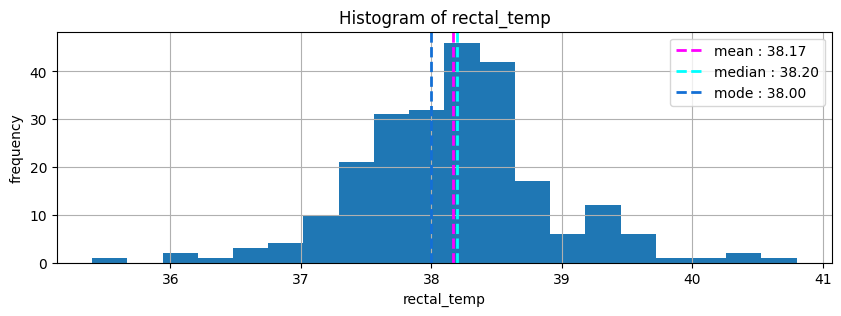

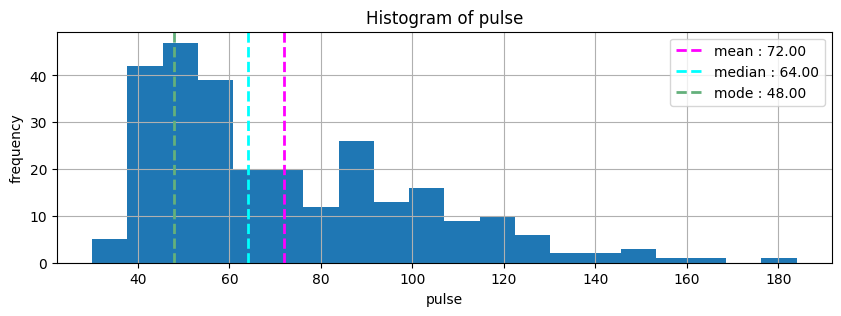

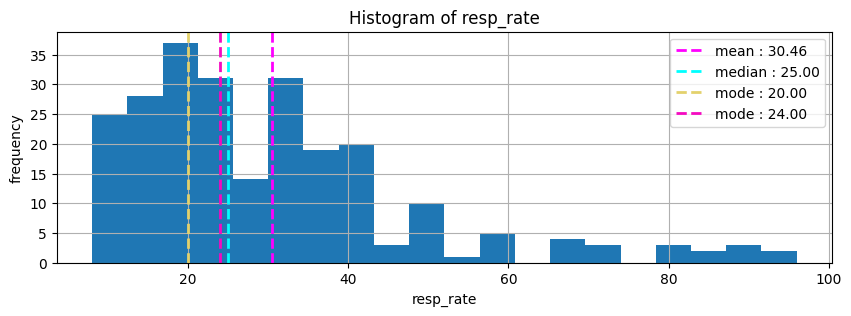

In [320]:
import matplotlib.pyplot as plt

for col in numeric_features:
    fig = plt.figure(figsize=(10,3))
    ax = fig.gca()
    feature = data[col].astype(float)
    feature.hist(bins=20,ax = ax)
    # data.astype(float).boxplot(by = col, ax = ax)
    mean_feature = ax.axvline(feature.astype(float).mean(), color = 'magenta',linestyle = 'dashed', linewidth=2, label='mean : {:0.2f}'.format(feature.astype(float).mean()))
    median_feature = ax.axvline(feature.astype(float).median(), color = 'cyan',linestyle = 'dashed', linewidth=2, label='median : {:0.2f}'.format(feature.astype(float).median()))
    for mode in feature.astype(float).mode():
        rgb = np.random.rand(3,)
        mode_feature = ax.axvline(mode, linestyle = 'dashed', color=rgb, linewidth=2, label='mode : {:0.2f}'.format(mode))
    ax.set_title('Histogram of ' + col)
    ax.set_ylabel('frequency')
    ax.set_xlabel(col)
    plt.legend()
plt.show()

In [321]:
import graphing

for col in categorical_features:
    graphing.histogram(data, label_x=col, label_colour='outcome_in_words', show=True)

In [322]:
# It may provide more insight to create a binary category for the outcome

def binary_outcome(y):
    outcomes = []
    for val in y:
        if val == 'lived':
            outcome = 1
        else:
            outcome = 0
        outcomes += [outcome]
    return outcomes

# Add new column with outcome in words
data.insert(0, 'binary_outcome', binary_outcome(data['outcome_in_words']),True)
test_data.insert(0, 'binary_outcome', binary_outcome(test_data['outcome_in_words']),True)
data.head()

,binary_outcome,outcome_in_words,had_surgery,age,hospital_number,rectal_temp,pulse,resp_rate,temp_of_extremities,peripheral_pulse,...,packed_cell_volume,total_protein,abdominocentesis_appearance,abdomcentesis_total_protein,outcome,had_surgical_lesion,lesion_site,lesion_type,lesion_subtype,lesion_specific_code
0,0,died,0,1,530101,38.5,66.0,28.0,3,3,...,45.0,8.4,NaN,NaN,2,2,11300,0,0,2
1,0,euthanized,1,1,534817,39.2,88.0,20.0,NaN,NaN,...,50.0,85.0,2,2.0,3,2,2208,0,0,2
2,1,lived,0,1,530334,38.3,40.0,24.0,1,1,...,33.0,6.7,NaN,NaN,1,2,0,0,0,1
3,0,died,1,2,5290409,39.1,164.0,84.0,4,1,...,48.0,7.2,3,5.3,2,1,2208,0,0,1
4,0,died,0,1,530255,37.3,104.0,35.0,NaN,NaN,...,74.0,7.4,NaN,NaN,2,2,4300,0,0,2


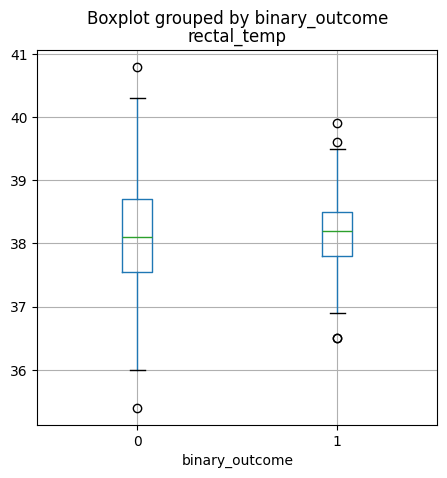

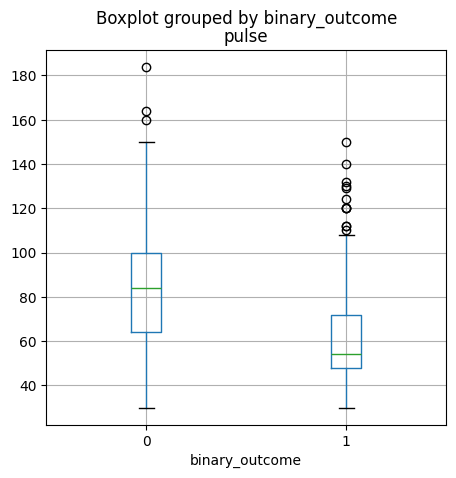

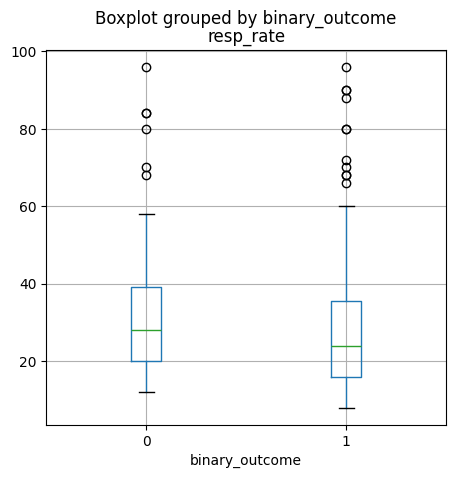

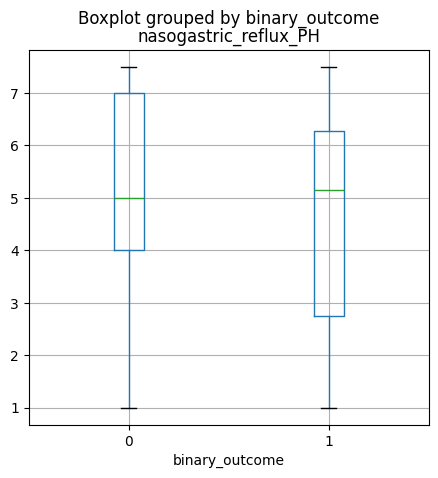

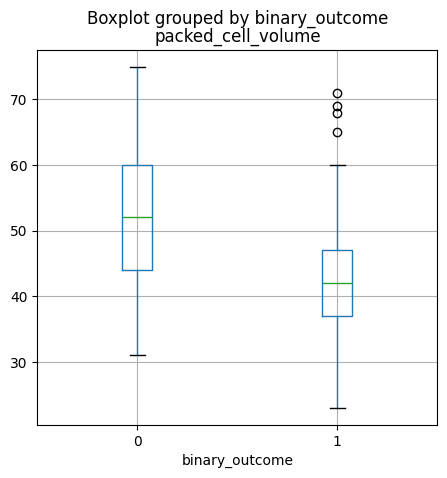

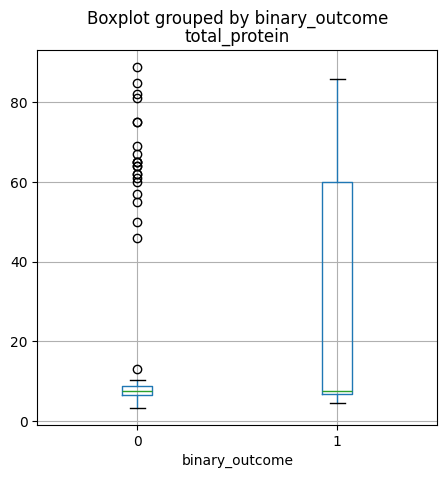

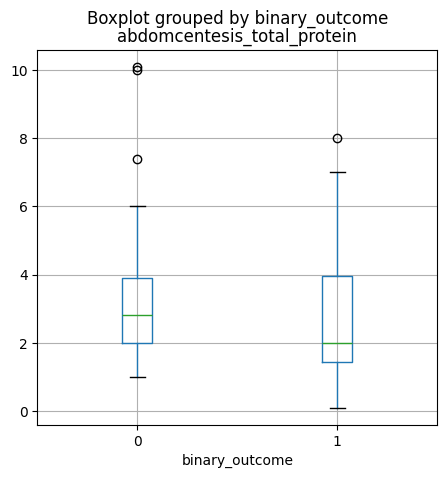

In [323]:
# Specify label column
label = 'binary_outcome'

# Plot numeric features as box and whisker plots
for col in all_numeric_features:
    data.boxplot(column=col, by=label,figsize=(5,5))
    plt.title(col)
plt.show()

Training cases: 299
Test cases: 67
HistGradientBoostingClassifier()
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       121
           1       0.99      1.00      1.00       178

    accuracy                           1.00       299
   macro avg       1.00      1.00      1.00       299
weighted avg       1.00      1.00      1.00       299



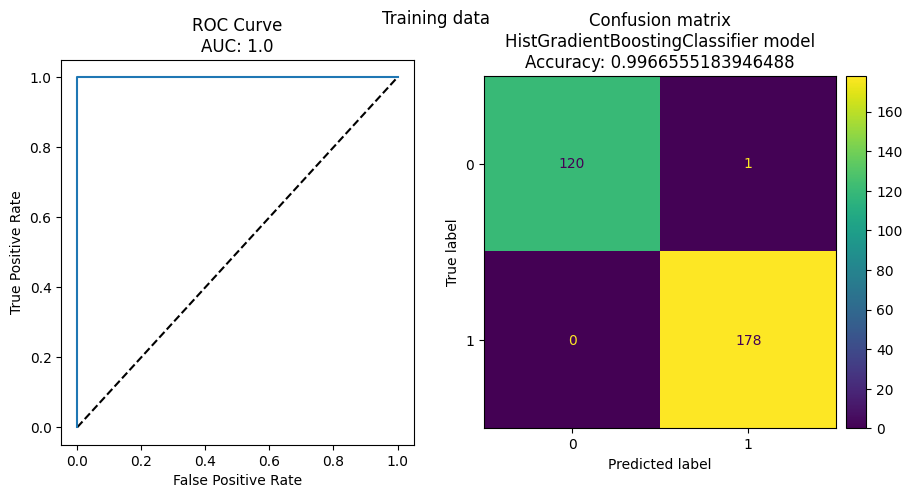

              precision    recall  f1-score   support

           0       0.58      0.75      0.65        20
           1       0.88      0.77      0.82        47

    accuracy                           0.76        67
   macro avg       0.73      0.76      0.74        67
weighted avg       0.79      0.76      0.77        67



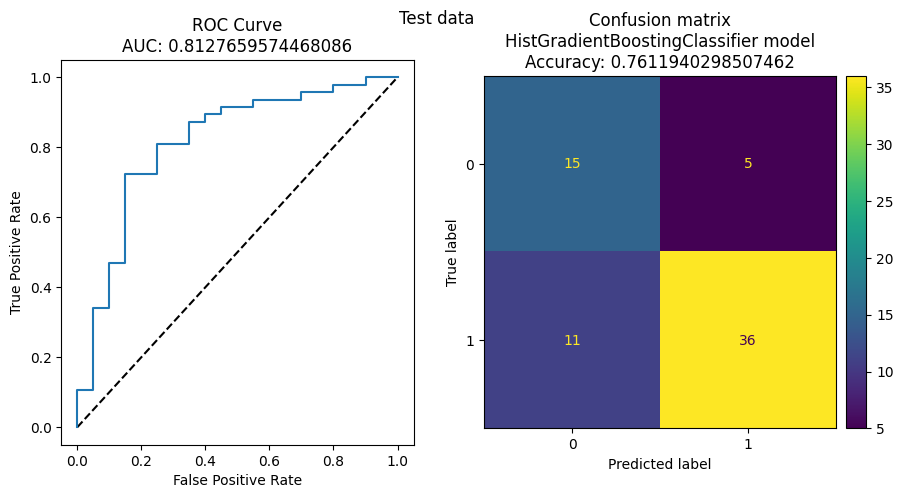

In [324]:
# Train the model
from sklearn.ensemble import HistGradientBoostingClassifier

# Combine features to be used in the model
numeric_features = ['rectal_temp','pulse','resp_rate','nasogastric_reflux_PH',
                   'packed_cell_volume','total_protein','abdomcentesis_total_protein']

categorical_features = ['had_surgery','age','temp_of_extremities',
                        'peripheral_pulse','mucous_membrane','capillary_refill_time',
                        'pain','peristalsis','abdominal_distension','nasogastric_tube',
                        'nasogastric_reflux','rectal_examination_feces','abdomen',
                        'had_surgical_lesion']
features = categorical_features + numeric_features

X_train, y_train = data[features], data[label]
X_test, y_test = test_data[features], test_data[label]
print ('Training cases: %d\nTest cases: %d' % (X_train.shape[0], X_test.shape[0]))

# Train
model = HistGradientBoostingClassifier().fit(X_train, y_train)
print(model)

def cm_roc_auc_plot(X,y,model,ttl='',do_show_plot = True):
    import sklearn
    from sklearn.metrics import accuracy_score, classification_report 
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    from sklearn.metrics import roc_curve, roc_auc_score
    import matplotlib.pyplot as plt

    predictions = model.predict(X)
    cm = confusion_matrix(y,predictions)
    y_scores = model.predict_proba(X)

    # calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y, y_scores[:,1])
    auc = roc_auc_score(y,y_scores[:,1])

    if do_show_plot:    
        print(classification_report(y, predictions))

        fig, ax = plt.subplots(1,2,figsize=(10, 5))

        # plot ROC curve
        # Plot the diagonal 50% line
        ax[0].plot([0, 1], [0, 1], 'k--')
        # Plot the FPR and TPR achieved by our model
        ax[0].plot(fpr, tpr)
        ax[0].set_xlabel('False Positive Rate')
        ax[0].set_ylabel('True Positive Rate')
        ax[0].set_title('ROC Curve\nAUC: ' + str(auc))

        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=ax[1], colorbar=False)
        disp.ax_.set_title('Confusion matrix\nHistGradientBoostingClassifier model\nAccuracy: '
                + str(accuracy_score(y, predictions)))
        # Adding custom colorbar
        cax = fig.add_axes([ax[1].get_position().x1+0.01,ax[1].get_position().y0,0.02,ax[1].get_position().height])
        plt.colorbar(disp.im_,  cax=cax)
        plt.suptitle(ttl)
        plt.show()

    return fpr, tpr, thresholds

cm_roc_auc_plot(X_train,y_train,model,'Training data')
cm_roc_auc_plot(X_test,y_test,model,'Test data');


This isn't half bad for a first model. However, it's clearly overtrained.

Now I'll try to improve the performance of the model by tuning the hyperparameters of the model. 

In [ ]:
# Tune some of the hyperparameters to see if we can improve the performance of the model on the test data.

Next I'll try adding a pipeline to preprocess the data.

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       121
           1       0.99      1.00      1.00       178

    accuracy                           1.00       299
   macro avg       1.00      1.00      1.00       299
weighted avg       1.00      1.00      1.00       299



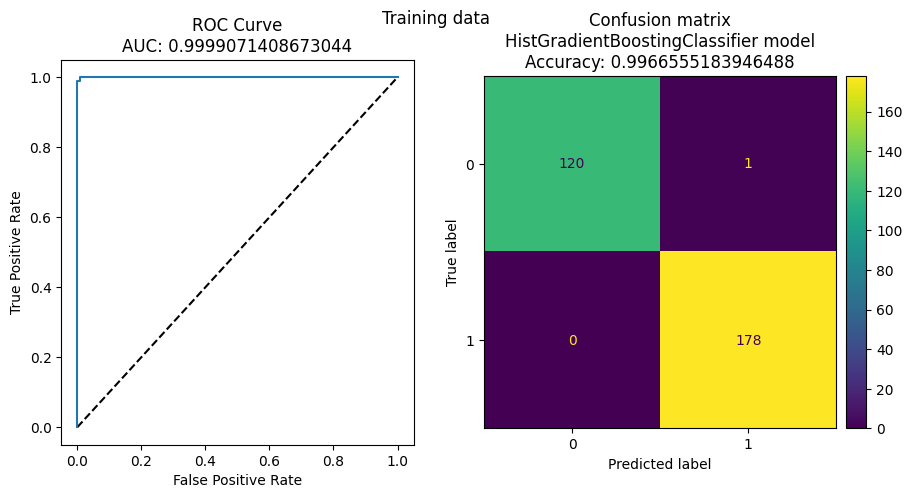

              precision    recall  f1-score   support

           0       0.62      0.65      0.63        20
           1       0.85      0.83      0.84        47

    accuracy                           0.78        67
   macro avg       0.73      0.74      0.74        67
weighted avg       0.78      0.78      0.78        67



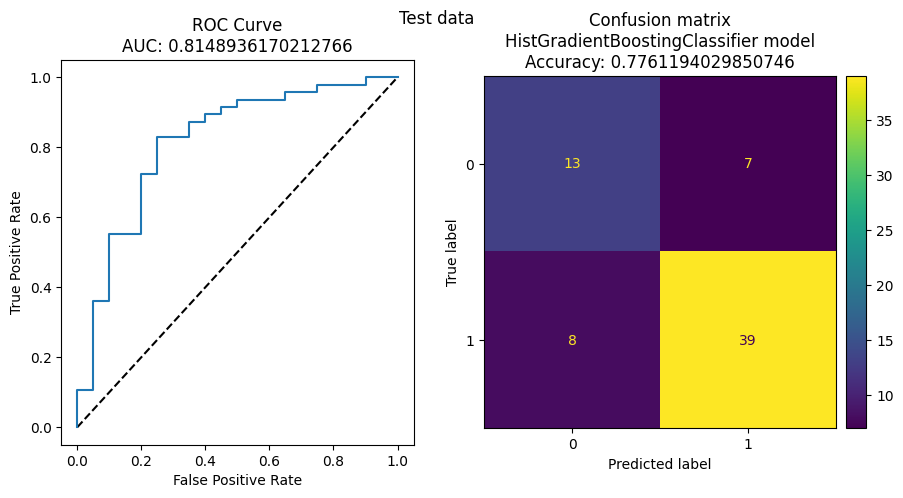

(array([0.  , 0.  , 0.  , 0.05, 0.05, 0.1 , 0.1 , 0.2 , 0.2 , 0.25, 0.25,
        0.35, 0.35, 0.4 , 0.4 , 0.45, 0.45, 0.5 , 0.5 , 0.65, 0.65, 0.75,
        0.75, 0.9 , 0.9 , 1.  ]),
 array([0.        , 0.0212766 , 0.10638298, 0.10638298, 0.36170213,
        0.36170213, 0.55319149, 0.55319149, 0.72340426, 0.72340426,
        0.82978723, 0.82978723, 0.87234043, 0.87234043, 0.89361702,
        0.89361702, 0.91489362, 0.91489362, 0.93617021, 0.93617021,
        0.95744681, 0.95744681, 0.9787234 , 0.9787234 , 1.        ,
        1.        ]),
 array([       inf, 0.99976849, 0.99635159, 0.99607281, 0.97619673,
        0.96802708, 0.91128899, 0.8756897 , 0.79102807, 0.7271317 ,
        0.53052049, 0.50747691, 0.46674715, 0.42536248, 0.35586865,
        0.35436438, 0.33768794, 0.33756857, 0.26884069, 0.12353581,
        0.09498244, 0.06824767, 0.05370312, 0.02824147, 0.02432195,
        0.00870762]))

In [325]:
# Train the model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

# Define preprocessing for numeric columns (normalize them so they're on the same scale)
num_feats = np.arange(len(categorical_features),len(categorical_features)+len(numeric_features))
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode the Age column)
cat_feats = np.arange(0,len(categorical_features))
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_feats),
        ('cat', categorical_transformer, cat_feats)])

# Create preprocessing and training pipeline
pipeline = make_pipeline(preprocessor,HistGradientBoostingClassifier())
# fit the pipeline to train a logistic regression model on the training set
model = pipeline.fit(X_train, y_train)

cm_roc_auc_plot(X_train, y_train, model, 'Training data')
cm_roc_auc_plot(X_test, y_test, model, 'Test data')

Next I'll try a simple logistic regression

In [326]:
import statsmodels.formula.api as smf

# This works best with fewer of the features
model = smf.logit("binary_outcome ~ rectal_temp + pulse", data).fit()

# Calculate accuracy
def calculate_accuracy(model):
    from sklearn.metrics import accuracy_score
    '''
    Calculates accuracy
    '''
    # Make estimations and convert to categories
    death_predicted = model.predict(data) > 0.5

    # Calculate what proportion were predicted correctly
    # We can use sklearn to calculate accuracy for us
    print("Accuracy:", accuracy_score(data.binary_outcome, death_predicted))

calculate_accuracy(model)
model.summary()

Optimization terminated successfully.
         Current function value: 0.561272
         Iterations 6
Accuracy: 0.6755852842809364


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         binary_outcome   No. Observations:                  233
Model:                          Logit   Df Residuals:                      230
Method:                           MLE   Df Model:                            2
Date:                Fri, 03 Nov 2023   Pseudo R-squ.:                  0.1381
Time:                        09:09:28   Log-Likelihood:                -130.78
converged:                       True   LL-Null:                       -151.73
Covariance Type:            nonrobust   LLR p-value:                 7.920e-10
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -15.3548      8.152     -1.884      0.060     -31.332       0.623
rectal_temp     0.4827      0.217      2.226      0.026       0.058       0.908
pulse          -0.0342      0.006     -5.696      0.000      -0.046      -0.022
===============================================================================
"""